In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

In [0]:
%tensorflow_version 2.x

In [3]:
import tensorflow as tf
tf.__version__

'2.2.0-rc2'

In [4]:
!pip install --upgrade git+https://github.com/titu1994/tfdiffeq.git 

  Cloning https://github.com/titu1994/tfdiffeq.git to /tmp/pip-req-build-eari68zl
  Running command git clone -q https://github.com/titu1994/tfdiffeq.git /tmp/pip-req-build-eari68zl
  Created wheel for tfdiffeq: filename=tfdiffeq-0.0.1-py2.py3-none-any.whl size=45904 sha256=e3ac04f3e21e9ff534a329a36bb2cd401290fe7f12fc694170854c0242286d21
  Stored in directory: /tmp/pip-ephem-wheel-cache-qfk2zu25/wheels/1a/fc/26/608bd5ecbf21d23b0e87bb71814d3c031b7c8a5b37fa7aa904
Successfully built tfdiffeq


In [5]:
!pip install pysindy

In [6]:
!pip install tensorflow_probability

In [7]:
!wget https://raw.githubusercontent.com/titu1994/keras_novograd/master/tf_novograd.py

--2020-04-05 03:41:50--  https://raw.githubusercontent.com/titu1994/keras_novograd/master/tf_novograd.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6082 (5.9K) [text/plain]
Saving to: ‘tf_novograd.py’

tf_novograd.py      100%[===================>]   5.94K  --.-KB/s    in 0s      

2020-04-05 03:41:50 (65.6 MB/s) - ‘tf_novograd.py’ saved [6082/6082]



In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from tfdiffeq import odeint
from tfdiffeq import plot_phase_portrait, plot_vector_field, plot_results
from tfdiffeq.sindy_utils import STRRidge

In [0]:
from tf_novograd import NovoGrad

In [0]:
NUM_SAMPLES = 1000
device = 'cpu:0' # These experiments do not require the GPU. Normally, 'gpu:0' if tf.test.is_gpu_available() else 'cpu:0' should be used.

# Force Float 64
tf.keras.backend.set_floatx('float64')

In [0]:
class LotkaVoltera(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.b, self.c, self.d = a, b, c, d
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)
    
    dR_dT = self.a * r - self.b * r * f
    dF_dT = -self.c * f + self.d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [0]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

In [14]:
%%time

with tf.device(device):
  result = odeint(LotkaVoltera(a, b, c, d), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)
CPU times: user 2.36 s, sys: 44.4 ms, total: 2.41 s
Wall time: 2.55 s


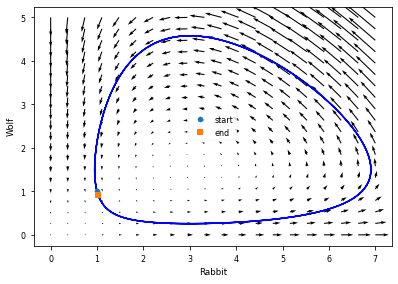

In [15]:
lims = [0, 5]
plot_phase_portrait(LotkaVoltera(a, b, c, d), xlabel='Rabbit', ylabel='Wolf', xlims=[0, 7], ylims=lims)
plot_vector_field(result, xlabel='Rabbit', ylabel='Wolf')

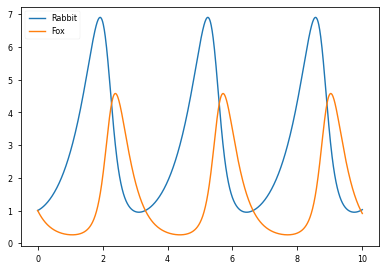

In [16]:
plot_results(t, result, labels=['Rabbit', 'Fox'])

# Now lets try to reconstruct the equations with NNs

In [0]:
class LotkaVolteraTrainable(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.c = a, c

    self.eqn = tf.keras.Sequential([
             tf.keras.layers.Dense(32, activation=tf.nn.swish, input_shape=(2,)),
             tf.keras.layers.Dense(32, activation=tf.nn.swish,),
             tf.keras.layers.Dense(32, activation=tf.nn.swish),
             tf.keras.layers.Dense(2, activation='relu',)   
    ])
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)

    # Neural ODE component
    n_out = self.eqn(tf.reshape(y, [1, 2]))  # [1, 2] -> [1, 2]
    pred1 = n_out[0, 0]
    pred2 = n_out[0, 1]
    
    dR_dT = self.a * r - pred1
    dF_dT = -self.c * f + pred2
    
    return tf.stack([dR_dT, dF_dT])

In [0]:
t_train = tf.linspace(0., 2., num=30)  # Train for just 3 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

epochs = 100
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5

# Train a model

We pretrain the model for a few epochs to reduce the loss quickly, and then retrain the model using BFGS to get the loss required to a small enough tolerance.

In [0]:
%%time

with tf.device(device):
  model = LotkaVolteraTrainable(a, b, c, d)

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

In [0]:
model.save_weights('model_weights/ckpt', save_format='tf')

In [24]:
model.load_weights('model_weights/ckpt')

## Finetune the model with BFGS

In [0]:
from tfdiffeq.bfgs_optimizer import BFGSOptimizer

In [0]:
tolerance = 1e-6
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

### Create a wrapper function for the BFGS optimizer 

```python
loss_value = loss(model)
```

In [0]:
from tfdiffeq.odeint import odeint as adjoint_odeint

def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-6, rtol=1e-6)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss

In [28]:
model = bfgs_optimizer.minimize(loss_wrapper, model)

Iter: 1 loss: 0.043752704723370416
Iter: 2 loss: 0.063939509615659168
Iter: 3 loss: 0.043699222165009127
Iter: 4 loss: 0.042009402347811711
Iter: 5 loss: 0.060428605818190741
Iter: 6 loss: 0.041830614152760917
Iter: 7 loss: 0.039418305382558173
Iter: 8 loss: 0.09913622429793
Iter: 9 loss: 0.039379933146001814
Iter: 10 loss: 0.035169604585747985
Iter: 11 loss: 0.041460106609949879
Iter: 12 loss: 0.032218342482224306
Iter: 13 loss: 0.031504040130539368
Iter: 14 loss: 0.027351652427859637
Iter: 15 loss: 0.031000477579940146
Iter: 16 loss: 0.023485710055288874
Iter: 17 loss: 0.031362694148225075
Iter: 18 loss: 0.019540665265762886
Iter: 19 loss: 0.1027101223077542
Iter: 20 loss: 0.018048981285561212
Iter: 21 loss: 0.10024326476280429
Iter: 22 loss: 0.016601175621587225
Iter: 23 loss: 0.19195786706782489
Iter: 24 loss: 0.016145005852804813
Iter: 25 loss: 0.018437527762761405
Iter: 26 loss: 0.014667852002545469
Iter: 27 loss: 0.016727470249943328
Iter: 28 loss: 0.013672558287561339
Iter: 29 

# Save your weights and download them !

In [0]:
model.save_weights('model_weights/ckpt', save_format='tf')

# Load a new model and load these weights (if you didnt train above)

In [0]:
import os
import requests

def get_checkpoints():
  if not os.path.exists('model_weights'):
      os.makedirs('model_weights')

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/checkpoint')
  with open('./model_weights/checkpoint', 'wb') as f:
    f.write(r.content)

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/ckpt.data-00000-of-00001')
  with open('./model_weights/ckpt.data-00000-of-00001', 'wb') as f:
    f.write(r.content)

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/ckpt.index')
  with open('./model_weights/ckpt.index', 'wb') as f:
    f.write(r.content)
  
  print("Pretrained checkpoints retrieved !")

In [0]:
get_checkpoints()

Pretrained checkpoints retrieved !


In [31]:
model = LotkaVolteraTrainable(a, b, c, d)
model.load_weights('model_weights/ckpt')

# Lets interpolate with our approximate universal ODE !

With a trained Neural ODE that appxoximates the Lotka Voltera system with just 30 samples, lets interpolate within the same timeframe to get a fine solution to the coarse approximate.

In [33]:
%%time

t_eval = tf.linspace(0., 2, num=1000)  # Re-evaluate for just 2 seconds of input, but 1000 timesteps

with tf.device(device):
    model_results = odeint(model, initial_states, t_eval)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states, t_eval)

CPU times: user 1.87 s, sys: 18.2 ms, total: 1.89 s
Wall time: 1.86 s


# Plot the ODE approximation !

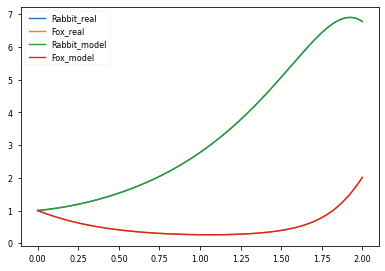

In [34]:
plot_results(t_eval, real_results, labels=['Rabbit_real', 'Fox_real'])
plot_results(t_eval, model_results, labels=['Rabbit_model', 'Fox_model'])

# Lets try and obtain the underlying equations of this system

In [0]:
real_results_np = real_results.numpy()
model_preds_np = model_results.numpy()
t_eval_np = t_eval.numpy()

In [0]:
from pysindy import SINDy
from pysindy import SR3
from pysindy.feature_library.polynomial_library import PolynomialLibrary

# Import the nice optimizer for Lasso regression !
from tfdiffeq.sindy_utils import STRRidge

# Optimize hyper parameters of SRTRidge and the Polynomial Library

In [0]:
# sindy_optm = SRTRidge(threshold=0.5, alpha=1.0)
sindy_optm = SR3(threshold=0.1, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=10, include_interaction=True,  interaction_only=True)

# Lets fit the SInDy model !

SInDy is short for "Sparse Identification of Non-linear Dynamical Systems" from the paper [Discovering governing equations from data by sparse identification of nonlinear dynamical systems](https://www.pnas.org/content/113/15/3932)

In [38]:
sindy_model = SINDy(optimizer=sindy_optm, feature_library=sindy_library, discrete_time=False)
sindy_model.fit(model_preds_np, t_eval_np)

SINDy(differentiation_method=<pysindy.differentiation.finite_difference.FiniteDifference object at 0x7fccc6eedc88>,
      discrete_time=False,
      feature_library=PolynomialLibrary(degree=10, include_bias=True,
                                        include_interaction=True,
                                        interaction_only=True, order='C'),
      feature_names=['x0', 'x1'], n_jobs=1,
      optimizer=SR3(copy_X=True, fit_intercept=False, max_iter=100,
                    normalize=False, nu=1.0, threshold=0.1, thresholder='l0',
                    tol=1e-05))

# Lets compare with the original equations

>$\frac{\partial R}{\partial T} = aR - bRF \\ \frac{\partial F}{\partial T} = -cF + dRF$

Recall, $a=1.5$, $b=1$, $c=3.0$, $d=1$

We substitute $bRF$ with $U_1(R, F)$ in $\frac{\partial R}{\partial T}$.

We substitute $bRF$ with $U_2(R, F)$ in $\frac{\partial F}{\partial T}$.

--------

We compare the above two equations with the one printed below.

We get $a'=1.225$ which is quite far off from $a=1.5$, $c'=3.031$, close to the original $c=3.0$.

The equation below approximates $b'=0.838$, far from the $b=1$ we expect. $d'=0.952$ is a closer approximate to our original $d=1$.


In [39]:
sindy_model.print()

x0' = 1.498 x0 + -0.997 x0 x1
x1' = -2.993 x1 + 0.999 x0 x1


In [40]:
sindy_model.coefficients()

array([[ 0.        ,  1.49801949,  0.        , -0.99657202],
       [ 0.        ,  0.        , -2.99258126,  0.99857371]])

In [41]:
sindy_model.equations()

['1.498 x0 + -0.997 x0 x1', '-2.993 x1 + 0.999 x0 x1']

# Compute the $R^2$ score 

In [42]:
sindy_model.score(model_preds_np, t_eval_np)  # 

0.9999294566666135

# Finding the correct coefficients for the model

We have the ode framework components which correspond to the neural network modules, but we cant be sure that the parameters found are correctly found by SInDy.

We can refit the model (but now replacing correct components and removing the corresponding neural network component), and try to estimate the parameters from the train set.

In [0]:
class LotkaVolteraParameters(tf.keras.Model):
  
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    
    # Can also initialize with the values found above for much faster convergence !
    self.parameters = tf.Variable(tf.random.uniform(shape=[4], dtype=tf.float64))
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)

    params = tf.nn.relu(self.parameters)
    a, b, c, d = tf.unstack(params)
    
    dR_dT = a * r - b * r * f
    dF_dT = -c * f + d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [0]:
t_train = tf.linspace(0., 3., num=30)  # Train for just 3 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

epochs = 100
initial_learning_rate = 0.1
decay_steps = 100
decay_rate = 0.5

In [46]:
%%time

with tf.device(device):
  model = LotkaVolteraParameters()

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

Computing ground truth...
Ground truth shape : (30, 2)
Epoch 1
Loss : 5.717302072893498
LR : 0.09930925

Epoch 2
Loss : 4.347992738804728
LR : 0.09862327

Epoch 3
Loss : 4.493248006193431
LR : 0.09794203

Epoch 4
Loss : 4.578560587704981
LR : 0.0972655

Epoch 5
Loss : 4.466186002428844
LR : 0.09659363

Epoch 6
Loss : 4.187422292189168
LR : 0.09592641

Epoch 7
Loss : 3.7893133392036935
LR : 0.0952638

Epoch 8
Loss : 3.3820840155116394
LR : 0.094605766

Epoch 9
Loss : 3.2648067654945034
LR : 0.093952276

Epoch 10
Loss : 3.039067314640337
LR : 0.0933033

Epoch 11
Loss : 2.854700700093036
LR : 0.09265881

Epoch 12
Loss : 3.1381763485407967
LR : 0.09201877

Epoch 13
Loss : 3.2745678096419035
LR : 0.09138315

Epoch 14
Loss : 3.179905369315509
LR : 0.090751916

Epoch 15
Loss : 2.980944740199846
LR : 0.09012505

Epoch 16
Loss : 2.784257268324426
LR : 0.089502506

Epoch 17
Loss : 2.6649115159445693
LR : 0.08888427

Epoch 18
Loss : 2.681516035211096
LR : 0.0882703

Epoch 19
Loss : 2.799089255908

In [0]:
tolerance = 1e-6
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [0]:
def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-6, rtol=1e-6)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss

In [49]:
model = bfgs_optimizer.minimize(loss_wrapper, model)

Iter: 1 loss: 0.16339081331797142
Iter: 2 loss: 0.42135137174741033
Iter: 3 loss: 0.16338256403758203
Iter: 4 loss: 0.16174139462093182
Iter: 5 loss: 4.442123394646555
Iter: 6 loss: 0.15128574863156449
Iter: 7 loss: 5.5109021247158827
Iter: 8 loss: 0.10735225698894796
Iter: 9 loss: 0.063764858834992777
Iter: 10 loss: 1.4688228119899944
Iter: 11 loss: 0.062569929263760427
Iter: 12 loss: 0.025252838160213013
Iter: 13 loss: 0.023671492619752085
Iter: 14 loss: 0.010968825753576565
Iter: 15 loss: 0.009786583676057144
Iter: 16 loss: 0.0051013474332513679
Iter: 17 loss: 0.13813414044491962
Iter: 18 loss: 0.0050745868389263831
Iter: 19 loss: 0.0015661806032238508
Iter: 20 loss: 0.019729912288467884
Iter: 21 loss: 0.0011869393402438922
Iter: 22 loss: 0.00019384882407128557
Iter: 23 loss: 0.00018881662830361873
Iter: 24 loss: 5.7328423882149992e-05
Iter: 25 loss: 0.00050302389891499931
Iter: 26 loss: 2.271165662726388e-05
Iter: 27 loss: 2.8482483120765409e-06
Iter: 28 loss: 0.0002113322946073843

## Lets print the learned parameters of this ODE

In [50]:
params = model.trainable_variables[0]
params.numpy().tolist()

[1.4999965409435712,
 0.9999973141865347,
 2.9999970191668344,
 0.9999972908862224]

# Finally, lets extrapolate the derived ODE !

In [51]:
%%time

a_dash = 1.4999965409435712
b_dash = 0.9999973141865347
c_dash = 2.9999970191668344
d_dash = 0.9999972908862224

t_extrapolate = tf.linspace(0., 10.0, num=1000)  # Train for just 3 seconds of input
initial_states_extrapolate = tf.convert_to_tensor([1, 1], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = LotkaVoltera(a_dash, b_dash, c_dash, d_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states_extrapolate, t_extrapolate)

CPU times: user 4.57 s, sys: 100 ms, total: 4.67 s
Wall time: 4.59 s


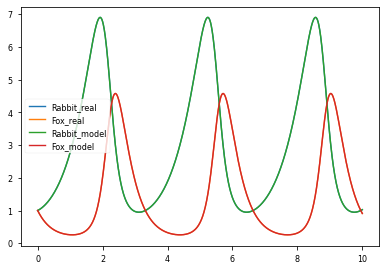

In [52]:
plot_results(t_extrapolate, real_results, labels=['Rabbit_real', 'Fox_real'])
plot_results(t_extrapolate, extrapolated_results, labels=['Rabbit_model', 'Fox_model'])